<a href="https://colab.research.google.com/github/crowell97/ES2245/blob/main/es2245_lecture5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salton Trough Earthquake Probability Analysis
## Forecasting Seismicity in Southern California

**Region:** Salton Trough (Coachella Valley to Mexican Border)
**Tectonic Context:** This area contains the southern San Andreas Fault, the San Jacinto Fault, and the Brawley Seismic Zone. It is one of the most tectonically complex and active regions in North America.

**Objective:**
1. Fetch recent seismic data specifically for the Salton Trough.
2. Calculate the local $b$-value (stress indicator).
3. Estimate the probability of significant rupture events in the near future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from datetime import datetime, timedelta

# Set visualization style
plt.style.use('ggplot')
print("Libraries loaded. Ready for analysis.")

Libraries loaded. Ready for analysis.


## 1. Data Acquisition (Geo-Filtered)
We will query the **USGS FDSN Web Service** to get data only within the bounding box of the Salton Trough.

**Bounding Box Parameters:**
* **North:** 34.1° (North of Palm Springs/Indio)
* **South:** 32.5° (Just south of the US-Mexico Border)
* **West:** -116.6° (Peninsular Ranges)
* **East:** -115.0° (Chocolate Mountains)
* **Timeframe:** Past 6 months (to ensure enough data points for a local region)

/tmp/ipython-input-3880461899.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_date = (datetime.utcnow() - timedelta(days=days)).strftime('%Y-%m-%d')


Fetching data for Salton Trough region...
Success: 506 earthquakes found in the past 180 days.


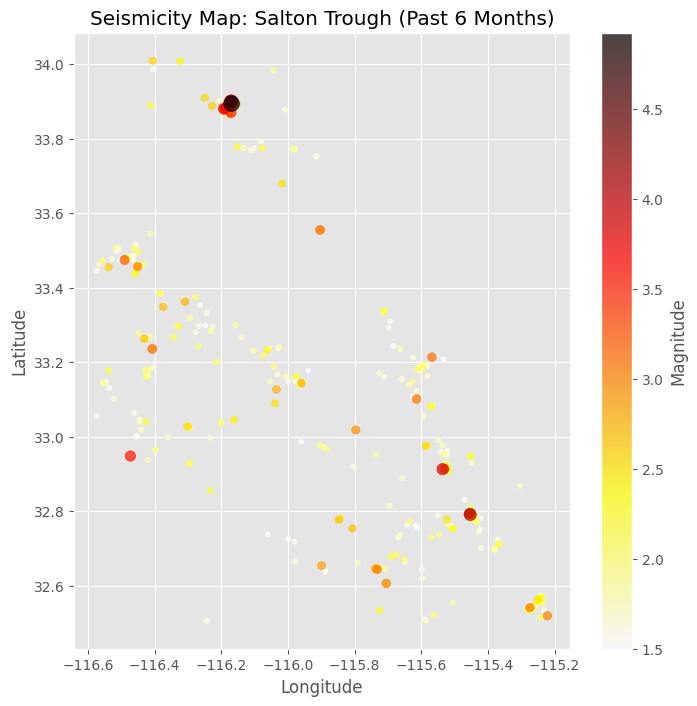

In [2]:
def fetch_salton_trough_data(days=180):
    # Calculate start time
    start_date = (datetime.utcnow() - timedelta(days=days)).strftime('%Y-%m-%d')

    # Salton Trough Bounding Box
    min_lat = 32.5
    max_lat = 34.1
    min_lon = -116.6
    max_lon = -115.0

    # Minimum magnitude (SoCal network is sensitive, so we can go lower than global)
    min_mag = 1.5

    # Construct API URL
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    query_params = (
        f"?format=csv"
        f"&starttime={start_date}"
        f"&minlatitude={min_lat}&maxlatitude={max_lat}"
        f"&minlongitude={min_lon}&maxlongitude={max_lon}"
        f"&minmagnitude={min_mag}"
        f"&orderby=time"
    )

    url = base_url + query_params
    print(f"Fetching data for Salton Trough region...")

    try:
        df = pd.read_csv(url)
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values(by='mag', ascending=True)
        print(f"Success: {len(df)} earthquakes found in the past {days} days.")
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_salton_trough_data()

# Quick visual check of the locations
if not df.empty:
    plt.figure(figsize=(8, 8))
    plt.scatter(df['longitude'], df['latitude'], c=df['mag'], cmap='hot_r', alpha=0.7, s=10 + (df['mag']**3))
    plt.colorbar(label='Magnitude')
    plt.title(f'Seismicity Map: Salton Trough (Past 6 Months)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print("No data found. Check your internet connection or API parameters.")

## 2. Gutenberg-Richter Analysis
We apply the law $\log_{10} N = a - bM$ to this specific dataset.

**Interpretation for Salton Trough:**
* **High b-value (>1.0):** Often seen in the **Brawley Seismic Zone** (geothermal areas, spreading centers) where swarms of small quakes are common.
* **Low b-value (<1.0):** Indicates high stress accumulation, often associated with locked patches of the **San Andreas** or **San Jacinto** faults.

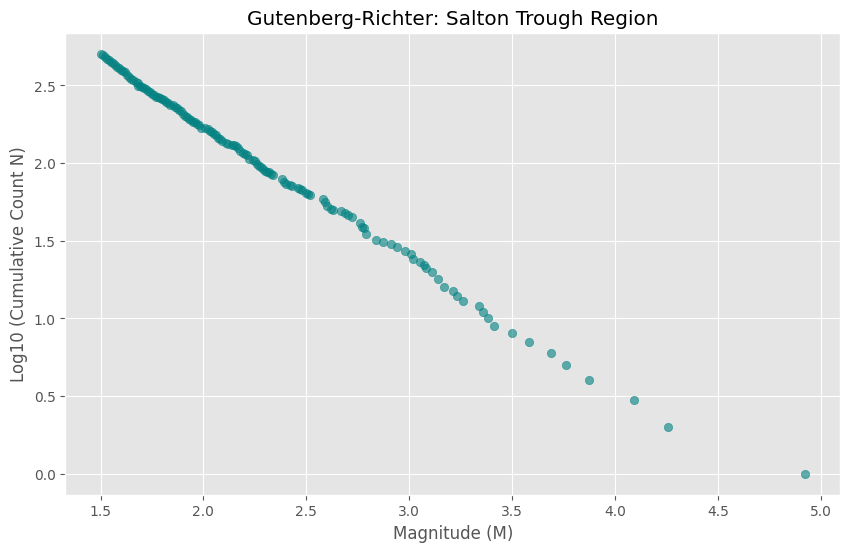

In [3]:
# 1. Get unique magnitudes
magnitudes = np.sort(df['mag'].unique())

# 2. Calculate Cumulative Frequency (N)
N_counts = [len(df[df['mag'] >= m]) for m in magnitudes]

# 3. Logarithm
log_N = np.log10(N_counts)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.scatter(magnitudes, log_N, label='Observed Data', color='teal', alpha=0.6)
plt.xlabel('Magnitude (M)')
plt.ylabel('Log10 (Cumulative Count N)')
plt.title('Gutenberg-Richter: Salton Trough Region')
plt.grid(True)
plt.show()

## 3. Calculating the Local b-value
Because the Southern California Seismic Network is very dense, the **Magnitude of Completeness ($M_c$)** is much lower than the global average. We can usually trust data down to M2.0 or even M1.8 in this valley.

We will use $M_c = 2.0$ for this calculation.

Regional b-value: 0.836
Regional a-value: 3.893
R-squared: 0.995


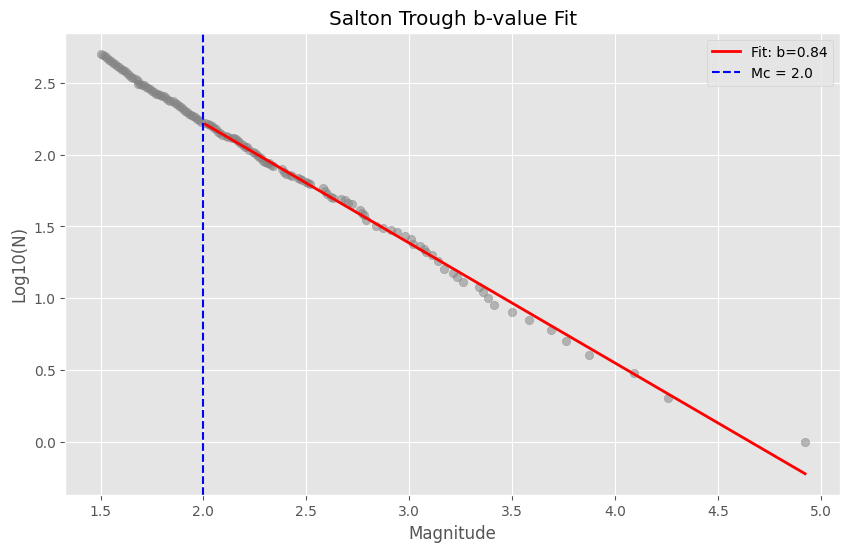

In [4]:
# Define Magnitude of Completeness for SoCal
Mc = 2.0

# Filter for linear portion
mask = magnitudes >= Mc
x_fit = magnitudes[mask]
y_fit = log_N[mask]

# Linear Regression
slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)

b_value = -slope
a_value = intercept

print(f"Regional b-value: {b_value:.3f}")
print(f"Regional a-value: {a_value:.3f}")
print(f"R-squared: {r_value**2:.3f}")

# Plot Fit
plt.figure(figsize=(10, 6))
plt.scatter(magnitudes, log_N, color='gray', alpha=0.5)
plt.plot(x_fit, slope * x_fit + intercept, color='red', linewidth=2, label=f'Fit: b={b_value:.2f}')
plt.axvline(x=Mc, color='blue', linestyle='--', label=f'Mc = {Mc}')
plt.xlabel('Magnitude')
plt.ylabel('Log10(N)')
plt.legend()
plt.title('Salton Trough b-value Fit')
plt.show()

## 4. Probability Forecast (Poisson)
We will forecast the probability of a moderate-to-large earthquake (e.g., M5.0+) occurring in the Salton Trough over the next year.

*Note: The "a-value" depends on the time duration of our data (6 months). We must normalize this to an annual rate before forecasting.*

In [5]:
def forecast_salton_event(target_mag, years, a, b, data_duration_days):
    # 1. Calculate N for the duration of the data
    log_N_period = a - (b * target_mag)
    N_period = 10 ** log_N_period

    # 2. Convert to Annual Rate (Lambda)
    # Scale based on how many days of data we fetched
    annual_rate_lambda = N_period * (365 / data_duration_days)

    # 3. Poisson Probability
    prob = 1 - np.exp(-annual_rate_lambda * years)

    return prob, annual_rate_lambda

# --- USER INPUTS ---
TARGET_M = 5.0     # Moderate earthquake (common in Imperial Valley)
YEARS = 1          # 1 Year forecast
DATA_DAYS = 180    # Must match the fetch function above

prob, rate = forecast_salton_event(TARGET_M, YEARS, a_value, b_value, DATA_DAYS)

print(f"--- SALTON TROUGH FORECAST ---")
print(f"Based on seismicity from the past {DATA_DAYS} days:")
print(f"Forecasting Magnitude: M{TARGET_M}+")
print(f"Estimated Annual Rate: {rate:.4f} events/year")
print(f"Probability of occurrence in the next {YEARS} years: {prob*100:.2f}%")

--- SALTON TROUGH FORECAST ---
Based on seismicity from the past 180 days:
Forecasting Magnitude: M5.0+
Estimated Annual Rate: 1.0412 events/year
Probability of occurrence in the next 1 years: 64.70%


## 5. Bayesian Statistics: Updating Our Beliefs
While the Gutenberg-Richter analysis gives us a "point estimate" (a single number) for the earthquake rate, **Bayesian Statistics** allows us to quantify our **uncertainty** about that rate.

In the Bayesian framework:
1.  **The Prior:** We start with a belief about the earthquake rate ( $\lambda$ ) before seeing this specific dataset.
2.  **The Likelihood:** We observe the actual data (how many quakes occurred).
3.  **The Posterior:** We update our belief. The result is not a single number, but a **probability distribution** of likely rates.

We will use a **Gamma-Poisson** conjugate model:
* **Poisson Process:** Earthquakes occur over time.
* **Gamma Distribution:** Represents our uncertainty about the rate $\lambda$.

Observation: 26 earthquakes >= M3.0 in 0.49 years.


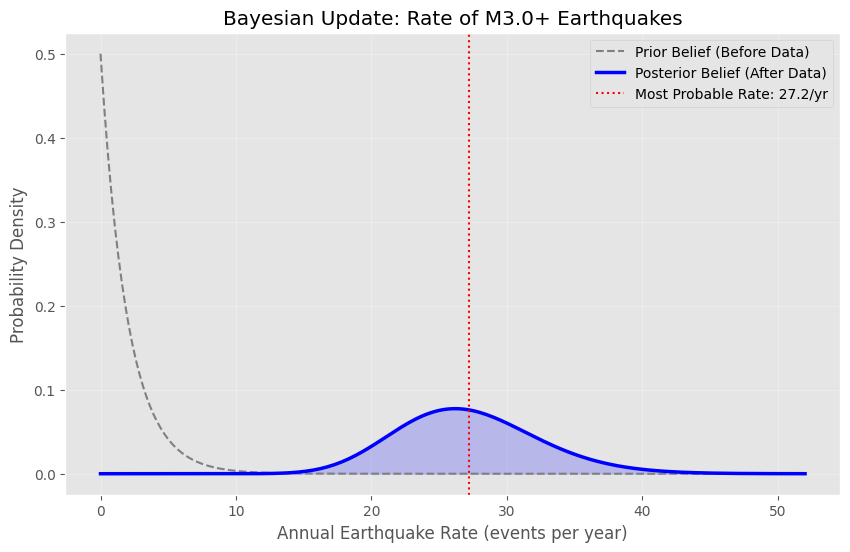

--- BAYESIAN CONCLUSION ---
Most likely rate: 27.19 events/year
95% Credible Interval: We are 95% confident the true rate is between 17.92 and 38.36 events/year.


In [6]:
from scipy.stats import gamma

# --- CONFIGURATION ---
# Let's analyze the rate of M3.0+ earthquakes (common enough to see a curve, large enough to care)
M_bayes_target = 3.0
observed_quakes = df[df['mag'] >= M_bayes_target]

# 1. Observed Data (Likelihood)
k_events = len(observed_quakes)        # Number of events (k)
t_years = DATA_DAYS / 365.0            # Time duration (t)

print(f"Observation: {k_events} earthquakes >= M{M_bayes_target} in {t_years:.2f} years.")

# 2. Define the PRIOR (Gamma Distribution)
# We use a 'Weak Prior' (uninformative), assuming we know very little beforehand.
# Alpha=1, Beta=0.5 implies we think the rate is low, but we are very uncertain (broad curve).
alpha_prior = 1.0
beta_prior = 0.5

# 3. Calculate the POSTERIOR (Gamma Update)
# The math is simple for Gamma-Poisson:
# New Alpha = Old Alpha + Count of Events
# New Beta  = Old Beta + Time Elapsed
alpha_post = alpha_prior + k_events
beta_post = beta_prior + t_years

# 4. Visualize Prior vs. Posterior
x_axis = np.linspace(0, max(20, k_events * 2), 200) # Range of rates to plot

# Generate distribution curves
y_prior = gamma.pdf(x_axis, a=alpha_prior, scale=1/beta_prior)
y_post = gamma.pdf(x_axis, a=alpha_post, scale=1/beta_post)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_prior, linestyle='--', color='gray', label='Prior Belief (Before Data)')
plt.plot(x_axis, y_post, color='blue', linewidth=2.5, label='Posterior Belief (After Data)')
plt.fill_between(x_axis, y_post, color='blue', alpha=0.2)

# Mark the Mean Estimate
mean_rate = alpha_post / beta_post
plt.axvline(mean_rate, color='red', linestyle=':', label=f'Most Probable Rate: {mean_rate:.1f}/yr')

plt.title(f'Bayesian Update: Rate of M{M_bayes_target}+ Earthquakes')
plt.xlabel('Annual Earthquake Rate (events per year)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Credible Interval (The Bayesian "Confidence Interval")
# What is the 95% probability range for the true rate?
lower_bound = gamma.ppf(0.025, a=alpha_post, scale=1/beta_post)
upper_bound = gamma.ppf(0.975, a=alpha_post, scale=1/beta_post)

print(f"--- BAYESIAN CONCLUSION ---")
print(f"Most likely rate: {mean_rate:.2f} events/year")
print(f"95% Credible Interval: We are 95% confident the true rate is between {lower_bound:.2f} and {upper_bound:.2f} events/year.")